In [ ]:
import polars as pl
import os
from tqdm import tqdm
from IPython.display import Markdown
import kagglehub
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from synthetic_data.screenplay_parser import ScreenplayParser

%load_ext autoreload
%autoreload 2

In [ ]:
scripts_corpus_path = kagglehub.dataset_download("veeralakrishna/imsdb-movie-scripts")
print(scripts_corpus_path)
scripts_pqt_path = os.path.join(scripts_corpus_path, "movie_scripts.parquet")
scripts_pqt = pl.read_parquet(scripts_pqt_path)

In [ ]:
for i in range(10):
    display(Markdown(f"## {scripts_pqt[i]['Movie'][0]}"))
    print(scripts_pqt[i]['Script'][0][0:1000])

In [22]:


scene_counts, char_line_counts = [], []
i, n_failed = 0, 0
good_scripts = []
for row in tqdm(scripts_pqt.iter_rows(named=True)):
    i += 1
    parser = ScreenplayParser(row['Script'])
    scenes = parser.parse()
    n_chars, n_chars_with_lines = len(scenes), len(parser.character_line_counts)
    scene_counts.append(n_chars)
    char_line_counts.append(n_chars_with_lines)
    if n_chars_with_lines >= 11 or n_chars >= 39:
        good_scripts.append(parser)
    if n_chars_with_lines == 0 and n_chars == 0:
        # print(row['Script'])
        n_failed += 1
        continue
    # print(f"Script {i} has {n_chars} scenes and {n_chars_with_lines} characters with lines")
    # for scene in scenes:
    #     display(Markdown(f"### {scene.heading.content}"))
    #     for elem in scene.elements:
    #         if elem.type == 'dialogue':
    #             if not elem.dialogue_data:
    #                 raise ValueError("Dialogue element has no dialogue data")
    #             display(Markdown(f"**{elem.dialogue_data.character}**: {elem.dialogue_data.content}"))

print(f"Failed to parse {n_failed} scripts")

1282it [00:04, 274.36it/s]

Failed to parse 380 scripts


[40, 50, 60]
char_cpts: [39.  52.5 67. ] scene_ct_percentiles: [11.4 43.  56. ]


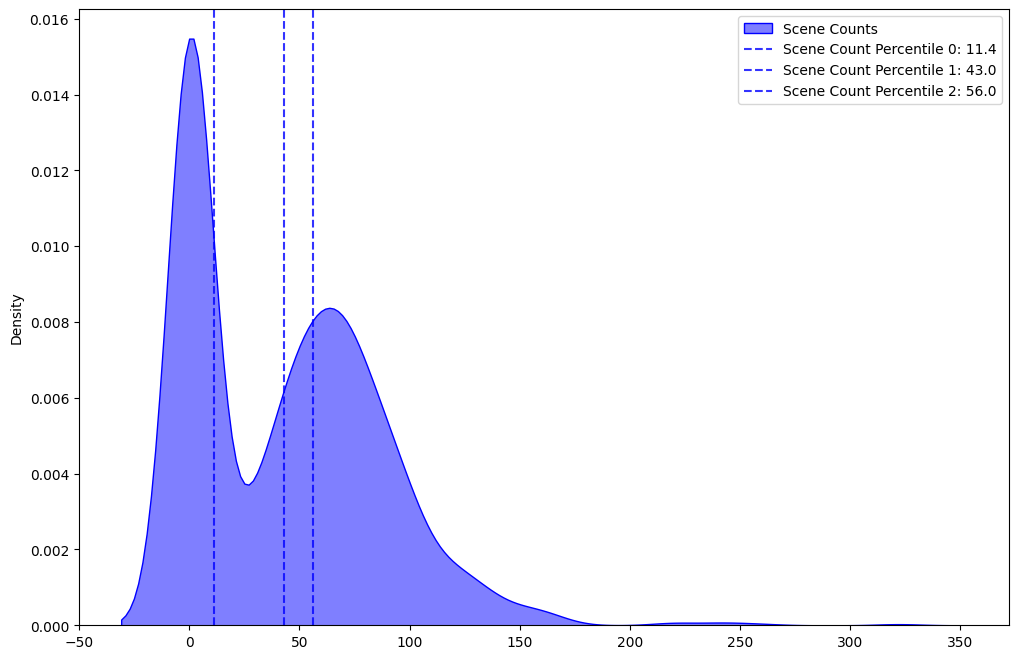

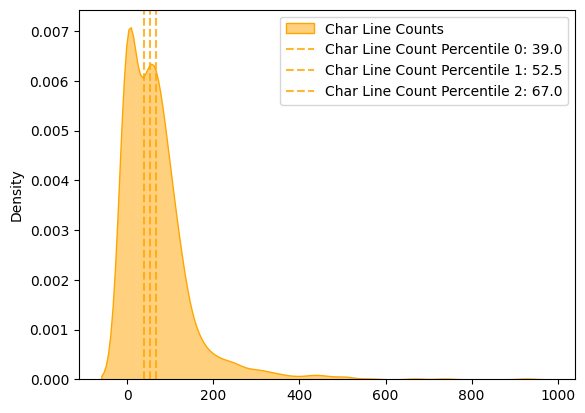

In [21]:
import seaborn as sns

scene_counts_np = pl.Series("char_counts", scene_counts).to_numpy()
char_line_counts_np = pl.Series("char_line_counts", char_line_counts).to_numpy()

pcts = [40, 50, 60]
print(pcts)
scene_ct_pcts = np.percentile(
    scene_counts_np, pcts
)
char_ct_pcts = np.percentile(char_line_counts_np, pcts)

print(f"char_cpts: {char_ct_pcts} scene_ct_percentiles: {scene_ct_pcts}")

# Plotting KDE with percentiles
plt.figure(figsize=(12, 8))

# KDE plots
sns.kdeplot(scene_counts_np, label="Scene Counts", fill=True, color="blue", alpha=0.5)

# Mark percentiles on the plot
for i, p in enumerate(scene_ct_pcts):
    plt.axvline(
        p,
        color="blue",
        linestyle="--",
        alpha=0.8,
        label=f"Scene Count Percentile {i}: {p:.1f}",
    )
plt.legend()

plt.show()
sns.kdeplot(
    char_line_counts_np, label="Char Line Counts", fill=True, color="orange", alpha=0.5
)

for i, p in enumerate(char_ct_pcts):
    plt.axvline(
        p,
        color="orange",
        linestyle="--",
        alpha=0.8,
        label=f"Char Line Count Percentile {i}: {p:.1f}",
    )

plt.legend()

# Display the plot
plt.show()

In [ ]:
good_scripts